## Importing modules

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import os, config, joblib

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from scipy.stats import randint, uniform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from shapely import wkt
from shapely.geometry import LineString, Polygon, MultiPolygon
from shapely.ops import transform, polygonize

from utils import Check_Valid, MergeDF, BufferMergeDF

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## Loading models

In [3]:
xgb_model = joblib.load(os.path.join(config.PROJECT_ROOT, 'models', 'xgb_final_model2.pkl'))
lgb_model = joblib.load(os.path.join(config.PROJECT_ROOT, 'models', 'lgb_final_model2.pkl'))
scaler = joblib.load(os.path.join(config.PROJECT_ROOT, 'models', 'scaler2.pkl'))

## Loading Data

In [4]:
commerce_path = os.path.join(config.DATA_DIR, '상권 영역 좌표/서울시 상권분석서비스(영역-상권).shp')
hinterland_path = os.path.join(config.DATA_DIR, '상권 배후지 영역 좌표/서울시 상권분석서비스(영역-상권배후지).shp')
dong_path = os.path.join(config.DATA_DIR, '행정동 영역 좌표/서울시 상권분석서비스(영역-행정동).shp')
lake_path = os.path.join(config.DATA_DIR, '하천 구역/LSMD_CONT_UJ201_11_202512.shp')
gu_path = os.path.join(config.DATA_DIR, '자치구 영역 좌표', '서울시 상권분석서비스(영역-자치구).shp')
road_path = os.path.join(config.DATA_DIR, '(도로명주소)도로구간_서울/TL_SPRD_MANAGE_11_202511.shp')
trash_path = os.path.join(config.DATA_DIR, '서울 쓰레기통 지오코딩/a.shp')

commerce = gpd.read_file(commerce_path, encoding='utf-8')
hinterland = gpd.read_file(hinterland_path, encoding='utf-8')
dong = gpd.read_file(dong_path, encoding='utf-8')
lake = gpd.read_file(lake_path)
gu = gpd.read_file(gu_path)
road = gpd.read_file(road_path, encoding='cp949')
trash = gpd.read_file(trash_path)

lake = lake.to_crs(commerce.crs)
road = road.to_crs(commerce.crs)
trash = trash.to_crs(commerce.crs)

lake_col, road_col, trash_col = lake.columns, road.columns, trash.columns

print("CRS Match:", True if commerce.crs == hinterland.crs == dong.crs == lake.crs == gu.crs == road.crs == trash.crs else False)
print("CRS:", commerce.crs)
gu_mapo = gu[gu.SIGNGU_NM == '마포구']
lake_mapo = lake.sjoin(gu_mapo, how='inner', predicate='intersects')[lake_col]
road_mapo = road.sjoin(gu_mapo, how='inner', predicate='intersects')[road_col]
trash_mapo = trash.sjoin(gu_mapo, how='inner', predicate='within')[trash_col]
commerce_mapo = commerce[commerce['SIGNGU_CD_'] == '마포구'].reset_index(drop=True)
hinterland_mapo = hinterland[hinterland['SIGNGU_CD_'] == '마포구'].reset_index(drop=True)
dong_mapo = dong[dong.ADSTRD_NM.isin(commerce_mapo.ADSTRD_CD_.unique().tolist())].reset_index(drop=True)

CRS Match: True
CRS: EPSG:5181


## Calculating square meter area of each polygon

In [5]:
seoul_commerce_mapo = commerce_mapo.copy()
seoul_hinterland_mapo = hinterland_mapo.copy()
seoul_dong_mapo = dong_mapo.copy()

seoul_commerce_mapo["area_m2"] = seoul_commerce_mapo.geometry.area
seoul_hinterland_mapo["area_m2"] = seoul_hinterland_mapo.geometry.area
seoul_dong_mapo["area_m2"] = seoul_dong_mapo.geometry.area

## Making grid

In [6]:
def create_grid(boundary, grid_size):
  minx, miny, maxx, maxy = boundary.bounds

  # 격자 좌표 생성
  x_coords = np.arange(minx, maxx, grid_size)
  y_coords = np.arange(miny, maxy, grid_size)

  grid_cells = []
  for x in x_coords:
    for y in y_coords:
      # 사각형(Cell) 생성
      cell = Polygon([
        (x, y),
        (x + grid_size, y),
        (x + grid_size, y + grid_size),
        (x, y + grid_size)
      ])

      if boundary.intersects(cell):
        grid_cells.append(boundary.intersection(cell))

  return grid_cells

In [7]:
grid_lines = create_grid(gu_mapo.geometry.values[0], 100)
grid_gdf = gpd.GeoDataFrame(
  grid_lines,
  columns=['geometry']
)

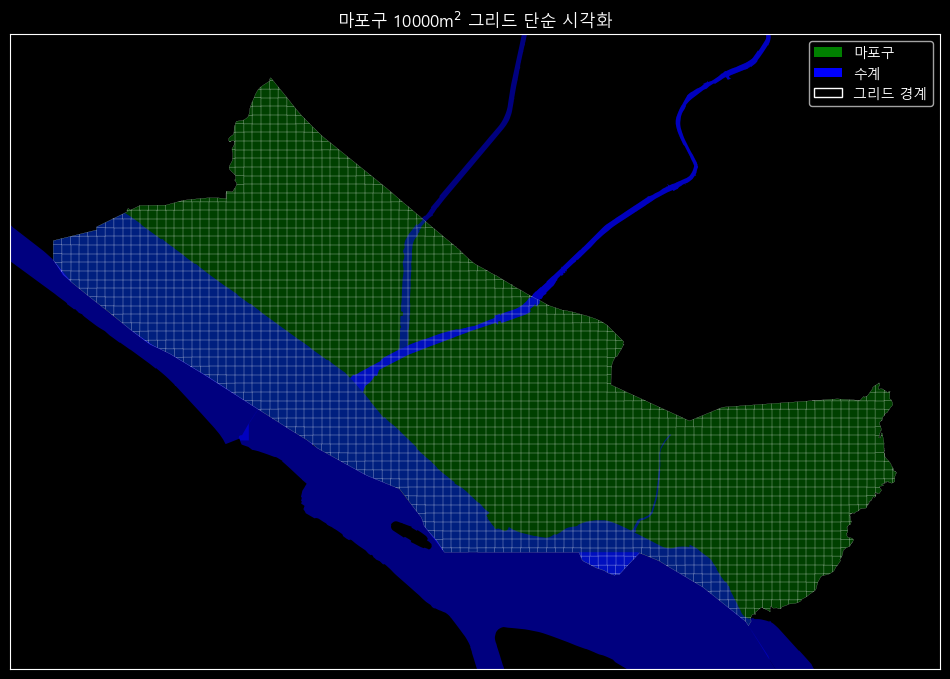

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
gu_mapo.plot(ax=ax, color='green', alpha=0.5)
lake_mapo.plot(ax=ax, color='blue', alpha=0.5)
grid_gdf.plot(ax=ax, color='none', edgecolor='white', linewidth=0.1)
legend_elements = [
    Patch(facecolor='green', label='마포구'),
    Patch(facecolor='blue', label='수계'),
    Patch(facecolor='none', edgecolor='white', linewidth=1, label='그리드 경계')
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
ax.grid(visible=False)
title = "마포구 10000m$^2$ 그리드 단순 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

In [9]:
# 상권: TRDAR_CD, 상권배후지: ALLEY_TRDA, 행정동: ADSTRD_CD

gu_ = gu_mapo[['geometry']]
grid_ = grid_gdf[['geometry']]
lake_ = lake_mapo[['geometry']]
comm_ = seoul_commerce_mapo[['TRDAR_CD', 'geometry']]
hint_ = seoul_hinterland_mapo[['ALLEY_TRDA', 'geometry']]
dong_ = seoul_dong_mapo[['ADSTRD_CD', 'geometry']]

lines = [gu_.geometry.boundary.union_all(), grid_gdf.geometry.boundary.union_all(), lake_.geometry.boundary.union_all()]

combined_all_lines = gpd.GeoSeries(lines).union_all()

divided_polygons = list(polygonize(combined_all_lines))

all_segmented = gpd.GeoDataFrame(geometry=divided_polygons, crs=gu_.crs)

all_segmented['centroid'] = all_segmented.geometry.centroid

all_segmented_mapped = all_segmented.set_geometry('centroid')

all_segmented_mapped = all_segmented_mapped.sjoin(comm_, how='left', predicate='within')
all_segmented_mapped.drop(columns='index_right', inplace=True, errors='ignore')

all_segmented_mapped = all_segmented_mapped.sjoin(hint_, how='left', predicate='within')
all_segmented_mapped.drop(columns='index_right', inplace=True, errors='ignore')

all_segmented_mapped = all_segmented_mapped.sjoin(dong_, how='inner', predicate='within')
all_segmented_mapped.drop(columns='index_right', inplace=True, errors='ignore')

lake_regions = all_segmented_mapped.sjoin(lake_, how='inner', predicate='within')
all_segmented_mapped = all_segmented_mapped.drop(lake_regions.index, axis=0)

all_segmented_final = all_segmented_mapped.set_geometry('geometry')

all_segmented_final = all_segmented_final.groupby(all_segmented_final.index).agg({
    'geometry': 'first',
    'centroid': 'first',
    'TRDAR_CD': lambda x: list(set(x.dropna())),
    'ALLEY_TRDA': lambda x: list(set(x.dropna())),
    'ADSTRD_CD': 'first'
})

all_segmented_final = gpd.GeoDataFrame(
    all_segmented_final,
    geometry='geometry',
    crs=gu_.crs
)

# leave areas over 400m^2
all_segmented_final['area_m2'] = all_segmented_final.geometry.area
all_segmented_final = all_segmented_final[all_segmented_final.area_m2 > 400]

In [10]:
all_segmented_final

,geometry,centroid,TRDAR_CD,ALLEY_TRDA,ADSTRD_CD,area_m2
0,"POLYGON ((190235.678 453864.937, 190247.585 45...",POINT (190195.494 453876.583),[],[],11440740,2461.255952
1,"POLYGON ((190247.585 453855.355, 190269.724 45...",POINT (190218.867 453804.468),[],[],11440740,9802.793214
2,"POLYGON ((190269.724 453837.539, 190282.556 45...",POINT (190303.583 453782.772),[],[],11440740,4177.279658
4,"POLYGON ((190371.341 453755.355, 190412.798 45...",POINT (190408.645 453690.25),[],[],11440740,6083.014250
6,"POLYGON ((190495.04 453655.355, 190510.111 453...",POINT (190512.463 453596.685),[],[],11440740,7756.560833
...,...,...,...,...,...,...
3128,"POLYGON ((196569.724 449955.355, 196569.724 45...",POINT (196619.724 450005.355),[3110590],"[3110588, 3110587, 3110589, 3110590]",11440565,10000.000000
3129,"POLYGON ((196569.724 450055.355, 196569.724 45...",POINT (196619.724 450105.355),[3110590],"[3110588, 3110587, 3110589, 3110590]",11440565,10000.000000
3130,"POLYGON ((196569.724 450755.355, 196569.724 45...",POINT (196619.724 450805.355),[],[],11440565,10000.000000
3131,"POLYGON ((196569.724 450855.355, 196569.724 45...",POINT (196619.724 450905.355),[],[],11440565,10000.000000


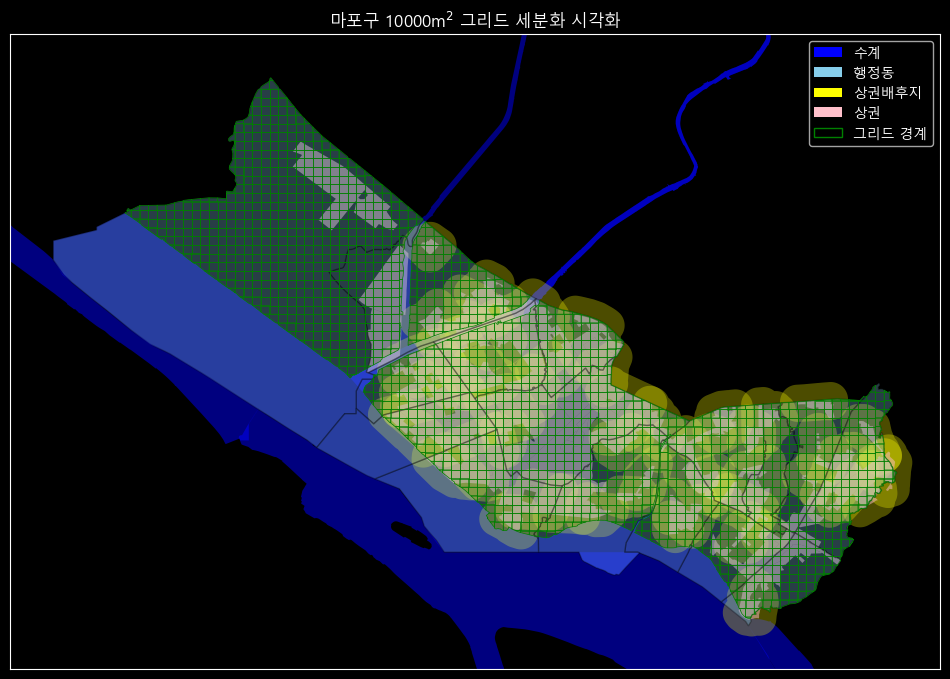

In [142]:
fig, ax = plt.subplots(figsize=(12, 10))
lake_mapo.plot(ax=ax, color='blue', alpha=0.5)
seoul_hinterland_mapo.plot(ax=ax, color='yellow', alpha=0.3)
seoul_commerce_mapo.plot(ax=ax, color='pink', alpha=0.5)
seoul_dong_mapo.plot(ax=ax, color='skyblue', edgecolor='black', alpha=0.3)
all_segmented_final.plot(ax=ax, color='none', edgecolor='green', linewidth=0.5)
# all_segmented_final.set_geometry('centroid').plot(ax=ax, color='red', markersize=0.2, alpha=0.5)
legend_elements = [
    Patch(facecolor='blue', label='수계'),
    Patch(facecolor='skyblue', label='행정동'),
    Patch(facecolor='yellow', label='상권배후지'),
    Patch(facecolor='pink', label='상권'),
    Patch(facecolor='none', edgecolor = 'green', linewidth=1, label='그리드 경계'),
    # Patch(facecolor='red', label='중심점')
]
ax.legend(handles=legend_elements)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
ax.grid(visible=False)
title = "마포구 10000m$^2$ 그리드 세분화 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

## Data Gathering

In [11]:
print(f'원본 상권 수: {len(seoul_commerce_mapo.TRDAR_CD)}')

data_topics = ['길단위인구', '상주인구', '소득소비', '아파트', '점포', '직장인구', '집객시설', '추정매출']

commerce_df = {}; hinterland_df = {}; dong_df = {}

cv = Check_Valid(
  source_data = seoul_commerce_mapo,
  source_col = 'TRDAR_CD',
  target_col = ['상권_코드']
)

hv = Check_Valid(
  source_data = seoul_hinterland_mapo,
  source_col = 'ALLEY_TRDA',
  target_col = ['상권배후지_코드', '상권_코드']
)

dv = Check_Valid(
  source_data = seoul_dong_mapo,
  source_col = 'ADSTRD_CD',
  target_col = ['행정동_코드']
)

for t in data_topics:
  commerce_df[t] = cv.print_out_valid(t, '서울 상권분석서비스(상권 기준)')
  hinterland_df[t] = hv.print_out_valid(t, '서울 상권분석서비스(상권 배후지 기준)')
  dong_df[t] = dv.print_out_valid(t, '서울 상권분석서비스(행정동 기준)')

원본 상권 수: 77
서울시 상권분석서비스(길단위인구-상권) valid 상권 수: 77
서울시 상권분석서비스(길단위인구-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(길단위인구-행정동) valid 상권 수: 16
서울시 상권분석서비스(상주인구-상권) valid 상권 수: 75
서울시 상권분석서비스(상주인구-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(상주인구-행정동) valid 상권 수: 16
서울시 상권분석서비스(소득소비-상권) valid 상권 수: 75
Trying with second target column: '상권배후지_코드'
서울시 상권분석서비스(소득소비-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(소득소비-행정동) valid 상권 수: 16
서울시 상권분석서비스(아파트-상권) valid 상권 수: 70
서울시 상권분석서비스(아파트-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(아파트-행정동) valid 상권 수: 16
서울시 상권분석서비스(점포-상권) valid 상권 수: 3760
Trying with second target column: '상권배후지_코드'
서울시 상권분석서비스(점포-상권배후지) valid 상권 수: 4079
서울시 상권분석서비스(점포-행정동) valid 상권 수: 1422
서울시 상권분석서비스(직장인구-상권) valid 상권 수: 76
서울시 상권분석서비스(직장인구-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(직장인구-행정동) valid 상권 수: 16
서울시 상권분석서비스(집객시설-상권) valid 상권 수: 73
서울시 상권분석서비스(집객시설-상권배후지) valid 상권 수: 51
서울시 상권분석서비스(집객시설-행정동) valid 상권 수: 16
서울시 상권분석서비스(추정매출-상권) valid 상권 수: 1014
Changing encoding method to utf-8: 'cp949' codec can't decode byte 0xa4 in p

## Connect Data to divided areas

In [12]:
bmdf = BufferMergeDF(all_segmented_final)

In [13]:
source_dict = {
  '길단위인구':['총_유동인구_수'],
  '상주인구':['총_상주인구_수', '총_가구_수'],
  '소득소비':['월_평균_소득_금액', '지출_총금액'],
  '아파트':['아파트_단지_수', '아파트_평균_면적', '아파트_평균_시가'],
  '직장인구':['총_직장_인구_수'],
  '집객시설':['집객시설_수']
}
# 세밀하게 분해
source_dict_ = {
  '길단위인구':['총_유동인구_수'], # 종속변수
  '상주인구':['연령대_10_상주인구_수', '연령대_20_상주인구_수', '연령대_30_상주인구_수', '연령대_40_상주인구_수', '연령대_50_상주인구_수', '연령대_60_이상_상주인구_수', '아파트_가구_수', '비_아파트_가구_수'],
  '소득소비':['월_평균_소득_금액', '식료품_지출_총금액', '의류_신발_지출_총금액', '생활용품_지출_총금액', '의료비_지출_총금액', '교통_지출_총금액', '교육_지출_총금액', '유흥_지출_총금액', '여가_문화_지출_총금액', '기타_지출_총금액', '음식_지출_총금액'],
  '아파트':['아파트_단지_수', '아파트_면적_66_제곱미터_미만_세대_수', '아파트_면적_66_제곱미터_세대_수', '아파트_면적_99_제곱미터_세대_수', '아파트_면적_132_제곱미터_세대_수', '아파트_면적_165_제곱미터_세대_수', '아파트_가격_1_억_미만_세대_수', '아파트_가격_1_억_세대_수', '아파트_가격_2_억_세대_수', '아파트_가격_3_억_세대_수', '아파트_가격_4_억_세대_수', '아파트_가격_5_억_세대_수', '아파트_가격_6_억_이상_세대_수', '아파트_평균_면적', '아파트_평균_시가'],
  '직장인구':['연령대_10_직장_인구_수', '연령대_20_직장_인구_수', '연령대_30_직장_인구_수', '연령대_40_직장_인구_수', '연령대_50_직장_인구_수', '연령대_60_직장_인구_수'],
  '집객시설':['관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수', '초등학교_수', '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수']
}

In [14]:
toilet_df = pd.read_csv(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시 공중화장실 위치정보.csv'), encoding='cp949')
park_df = pd.read_csv(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시 녹지대 위치정보.csv'), encoding='cp949')
subway_df = pd.read_csv(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시 역사마스터 정보.csv'), encoding='cp949')
bus_df = pd.read_excel(os.path.join(config.DATA_DIR, '공공시설 위치 데이터', '서울시버스정류소위치정보.xlsx'))

In [15]:
toilet_gdf = gpd.GeoDataFrame(
  toilet_df,
  geometry=gpd.points_from_xy(toilet_df['x 좌표'], toilet_df['y 좌표']),
  crs="EPSG:4326"
)
park_gdf = gpd.GeoDataFrame(
  park_df,
  geometry=gpd.points_from_xy(park_df['X 좌표'], park_df['Y 좌표']),
  crs="EPSG:5181"
)
subway_gdf = gpd.GeoDataFrame(
  subway_df,
  geometry=gpd.points_from_xy(subway_df['경도'], subway_df['위도']),
  crs="EPSG:4326"
)
bus_gdf = gpd.GeoDataFrame(
  bus_df,
  geometry=gpd.points_from_xy(bus_df['X좌표'], bus_df['Y좌표']),
  crs="EPSG:4326"
)
toilet_gdf = toilet_gdf.to_crs(epsg=5181)
subway_gdf = subway_gdf.to_crs(epsg=5181)
bus_gdf = bus_gdf.to_crs(epsg=5181)

In [16]:
toilet_gdf_col = toilet_gdf.columns
park_gdf_col = park_gdf.columns
subway_gdf_col = subway_gdf.columns
bus_gdf_col = bus_gdf.columns

toilet_gdf_mapo = toilet_gdf.sjoin(gu_mapo, how='inner', predicate='within')[toilet_gdf_col]
park_gdf_mapo = park_gdf.sjoin(gu_mapo, how='inner', predicate='within')[park_gdf_col]
subway_gdf_mapo = subway_gdf.sjoin(gu_mapo, how='inner', predicate='within')[subway_gdf_col]
bus_gdf_mapo = bus_gdf.sjoin(gu_mapo, how='inner', predicate='within')[bus_gdf_col]

In [17]:
public_df = {
  '지하철':subway_gdf_mapo,
  '버스':bus_gdf_mapo,
  '공원':park_gdf_mapo,
  '화장실':toilet_gdf_mapo,
}
public_source_dict = {
  '지하철':[800, 1200],
  '버스':[400, 800],
  '공원':[300, 600],
  '화장실':[400, 800],
}

In [18]:
# 즉석판매제조가공업, 건강기능식품일반판매업(영업장판매), 미용업, 일반음식점, 휴게음식점(커피숍, 편의점)
instant = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_22_19_P_즉석판매제조가공업.csv'), encoding='cp949', low_memory=False)
health = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_22_03_P_건강기능식품일반판매업.csv'), encoding='cp949', low_memory=False)
beauty = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_05_18_01_P_미용업.csv'), encoding='cp949', low_memory=False)
food = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_24_04_P_일반음식점.csv'), encoding='cp949', low_memory=False)
coff_conv = pd.read_csv(os.path.join(config.DATA_DIR, '지방인허가행정데이터', '6110000_서울특별시_07_24_05_P_휴게음식점.csv'), encoding='cp949', low_memory=False)

In [19]:
instant_df = instant[instant['영업상태명']=='영업/정상']
health_df = health[health['영업상태명']=='영업/정상']
health_df = health_df[health_df['위생업태명']=='영업장판매']
beauty_df = beauty[beauty['영업상태명']=='영업/정상']
food_df = food[food['영업상태명']=='영업/정상']
coff_conv_df = coff_conv[coff_conv['영업상태명']=='영업/정상']
coff_df = coff_conv_df[coff_conv_df['업태구분명']=='커피숍']
conv_df = coff_conv_df[coff_conv_df['업태구분명']=='편의점']

In [20]:
instant_gdf = gpd.GeoDataFrame(
  instant_df,
  geometry=gpd.points_from_xy(instant_df['좌표정보x(epsg5174)'], instant_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
health_gdf = gpd.GeoDataFrame(
  health_df,
  geometry=gpd.points_from_xy(health_df['좌표정보x(epsg5174)'], health_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
beauty_gdf = gpd.GeoDataFrame(
  beauty_df,
  geometry=gpd.points_from_xy(beauty_df['좌표정보x(epsg5174)'], beauty_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
food_gdf = gpd.GeoDataFrame(
  food_df,
  geometry=gpd.points_from_xy(food_df['좌표정보x(epsg5174)'], food_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
coff_gdf = gpd.GeoDataFrame(
  coff_df,
  geometry=gpd.points_from_xy(coff_df['좌표정보x(epsg5174)'], coff_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)
conv_gdf = gpd.GeoDataFrame(
  conv_df,
  geometry=gpd.points_from_xy(conv_df['좌표정보x(epsg5174)'], conv_df['좌표정보y(epsg5174)']),
  crs="EPSG:5174"
)

instant_gdf = instant_gdf.to_crs(epsg=5181)
health_gdf = health_gdf.to_crs(epsg=5181)
beauty_gdf = beauty_gdf.to_crs(epsg=5181)
food_gdf = food_gdf.to_crs(epsg=5181)
coff_gdf = coff_gdf.to_crs(epsg=5181)
conv_gdf = conv_gdf.to_crs(epsg=5181)

In [21]:
instant_gdf_col = instant_gdf.columns
health_gdf_col = health_gdf.columns
beauty_gdf_col = beauty_gdf.columns
food_gdf_col = food_gdf.columns
coff_gdf_col = coff_gdf.columns
conv_gdf_col = conv_gdf.columns

instant_gdf_mapo = instant_gdf.sjoin(gu_mapo, how='inner', predicate='within')[instant_gdf_col]
health_gdf_mapo = health_gdf.sjoin(gu_mapo, how='inner', predicate='within')[health_gdf_col]
beauty_gdf_mapo = beauty_gdf.sjoin(gu_mapo, how='inner', predicate='within')[beauty_gdf_col]
food_gdf_mapo = food_gdf.sjoin(gu_mapo, how='inner', predicate='within')[food_gdf_col]
coff_gdf_mapo = coff_gdf.sjoin(gu_mapo, how='inner', predicate='within')[coff_gdf_col]
conv_gdf_mapo = conv_gdf.sjoin(gu_mapo, how='inner', predicate='within')[conv_gdf_col]

In [22]:
# 즉석판매제조가공업, 건강기능식품일반판매업(영업장판매), 미용업, 일반음식점, 휴게음식점(커피숍, 편의점)
store_df = {
  '즉석판매제조가공업':instant_gdf_mapo,
  '건강기능식품일반판매업':health_gdf_mapo,
  '미용업':beauty_gdf_mapo,
  '일반음식점':food_gdf_mapo,
  '커피숍':coff_gdf_mapo,
  '편의점':conv_gdf_mapo,
}
store_source_dict = {
  '즉석판매제조가공업':[500, 1000],
  '건강기능식품일반판매업':[500, 1000],
  '미용업':[500, 1000],
  '일반음식점':[500, 1000],
  '커피숍':[500, 1000],
  '편의점':[500, 1000],
}

In [23]:
for k, v_list in source_dict.items():
  for v in v_list:
    bmdf.run([commerce_df[k], hinterland_df[k], dong_df[k]], v)
for pk, r_list in public_source_dict.items():
  for r in r_list:
    bmdf.buffer_merge(public_df[pk], pk, r)
for sk, r_list in store_source_dict.items():
  for r in r_list:
    bmdf.buffer_merge(store_df[sk], sk, r)

Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead of rep_point
Attribute Error occurred in making buffer: Try centroids instead

In [24]:
bmdf.merged_df

,geometry,centroid,TRDAR_CD,ALLEY_TRDA,ADSTRD_CD,area_m2,총_유동인구_수_밀도_평균,총_상주인구_수_밀도_평균,총_가구_수_밀도_평균,월_평균_소득_금액_밀도_평균,...,건강기능식품일반판매업_수_500m,건강기능식품일반판매업_수_1000m,미용업_수_500m,미용업_수_1000m,일반음식점_수_500m,일반음식점_수_1000m,커피숍_수_500m,커피숍_수_1000m,편의점_수_500m,편의점_수_1000m
0,"POLYGON ((190235.678 453864.937, 190247.585 45...",POINT (190195.494 453876.583),[],[],11440740,2461.255952,0.640404,0.003530,0.001511,0.494916,...,11,35,22,66,160,497,30,70,7,15
1,"POLYGON ((190247.585 453855.355, 190269.724 45...",POINT (190218.867 453804.468),[],[],11440740,9802.793214,0.640404,0.003530,0.001511,0.494916,...,14,35,27,67,220,545,39,74,8,15
2,"POLYGON ((190269.724 453837.539, 190282.556 45...",POINT (190303.583 453782.772),[],[],11440740,4177.279658,0.640404,0.003530,0.001511,0.494916,...,15,36,27,74,220,577,41,76,9,15
3,"POLYGON ((190371.341 453755.355, 190412.798 45...",POINT (190408.645 453690.25),[],[],11440740,6083.014250,0.640404,0.003530,0.001511,0.494916,...,16,38,31,74,243,610,45,82,7,19
4,"POLYGON ((190495.04 453655.355, 190510.111 453...",POINT (190512.463 453596.685),[],[],11440740,7756.560833,0.640404,0.003530,0.001511,0.494916,...,17,37,33,73,307,605,44,79,7,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,"POLYGON ((196569.724 449955.355, 196569.724 45...",POINT (196619.724 450005.355),[3110590],"[3110588, 3110587, 3110589, 3110590]",11440565,10000.000000,15.884680,0.035197,0.018501,16.848711,...,2,25,27,145,102,465,9,49,4,16
1931,"POLYGON ((196569.724 450055.355, 196569.724 45...",POINT (196619.724 450105.355),[3110590],"[3110588, 3110587, 3110589, 3110590]",11440565,10000.000000,15.884680,0.035197,0.018501,16.848711,...,5,22,30,126,99,454,8,44,5,15
1932,"POLYGON ((196569.724 450755.355, 196569.724 45...",POINT (196619.724 450805.355),[],[],11440565,10000.000000,11.963233,0.035740,0.018209,3.971460,...,0,15,12,82,24,210,4,27,1,12
1933,"POLYGON ((196569.724 450855.355, 196569.724 45...",POINT (196619.724 450905.355),[],[],11440565,10000.000000,11.963233,0.035740,0.018209,3.971460,...,0,15,12,75,23,187,4,24,1,12


In [25]:
bmdf.merged_df.to_csv(os.path.join(config.PROJECT_ROOT, 'preprocessed_data', '유동인구_최종_데이터2.csv'), index=False, encoding='cp949')
bmdf.merged_df.to_csv(os.path.join(config.PROJECT_ROOT, 'preprocessed_data', '유동인구_최종_데이터(utf-8)2.csv'), index=False, encoding='utf-8')

## Model Prediction

In [26]:
final_df_path = os.path.join(config.PROJECT_ROOT, 'preprocessed_data', '유동인구_최종_데이터(utf-8)2.csv')
final_df = gpd.read_file(final_df_path, encoding='utf-8')
final_df['geometry'] = final_df['geometry'].apply(wkt.loads)
final_df['centroid'] = final_df['centroid'].apply(wkt.loads)

In [27]:
float_col = final_df.filter(like='평균').columns
int_col = final_df.filter(regex='^(?!.*평균).*수.*').columns

final_df[float_col] = final_df[float_col].astype(float)
final_df[int_col] = final_df[int_col].astype(int)

In [29]:
X = final_df.drop(['geometry', 'centroid', 'TRDAR_CD', 'ALLEY_TRDA', 'ADSTRD_CD', 'area_m2',  '총_유동인구_수_밀도_평균', 'area_m2'], axis=1)
X_scaled = scaler.transform(X)

In [30]:
y_pred = xgb_model.predict(X_scaled)
real_y_pred = np.expm1(y_pred)
final_df['y_pred'] = real_y_pred

In [31]:
final_df.to_csv(os.path.join(config.PROJECT_ROOT, 'preprocessed_data', '유동인구_최종_예측_데이터2.csv'), index=False, encoding='utf-8')

## Visualiziaing Prediction

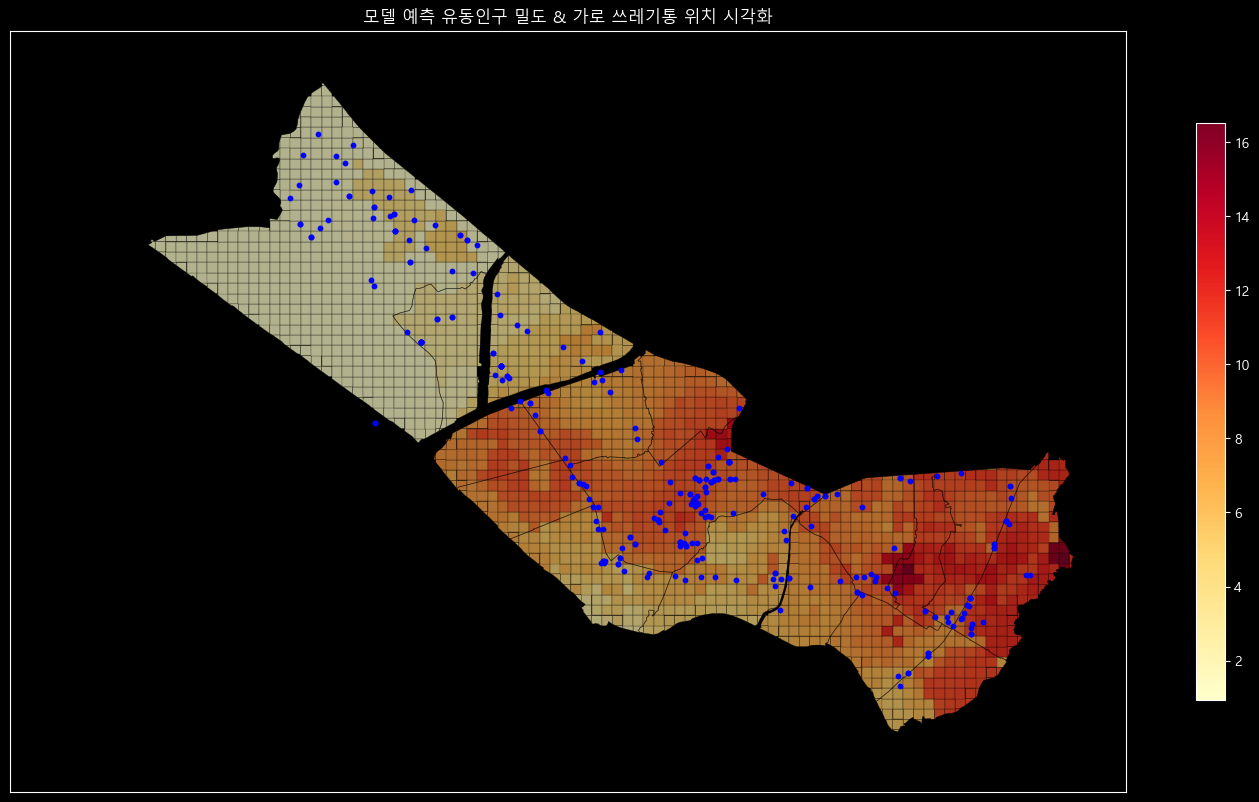

In [33]:
fig, ax = plt.subplots(figsize=(18, 15))
final_df.set_geometry('geometry').plot(ax=ax, edgecolor='black', linewidth=0.3, column='y_pred', cmap='YlOrRd', legend=True, alpha=0.7,
                                       legend_kwds={
                                         'shrink': 0.5,
                                         'aspect': 20,
                                         'orientation': "vertical"
                                       })
seoul_dong_mapo.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, alpha=0.5)
trash_mapo.plot(ax=ax, color='blue', markersize=10)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
ax.grid(visible=False)
title = "모델 예측 유동인구 밀도 & 가로 쓰레기통 위치 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()

### 고려사항
- 도시청결에 영향을 미치는 도시환경요인에 관한 연구 - 서울시를 중심으로 - (송이슬/김흥순)
> 평균 시민만족도는 22.24점, 평균 현장청결도는 45.25점으로 나타났다
- 도시청결에 영향을 미치는 도시환경요인에 관한 연구 - 서울시를 중심으로 - (Cont'd)
> 유동인구밀도가 1천명/km$^2$ 증가할 때 시민만족도 점수는 0.0001점 감소하는 것으로 나타났는데 이는 유동인구밀도가 높은 지역은 사람의 활동이 많이 일어나는 곳이기에 지속적인 청소가 이루어져도 만족도가 낮을 수 있고 청소가 제대로 이루지지 못하는 경우도 있기에 부의 영향이 나타난 것으로 판단된다(이상혁 외, 2011).
- 도시청결에 영향을 미치는 도시환경요인에 관한 연구 - 서울시를 중심으로 - (Cont'd)
> 유동인구밀도가 1천명/km$^2$ 증가할 때 현장청결도 점수는 0.0004점 감소하는 것으로 나타났다. -> **10000m$^2$당 10명 증가할 때 0.0004점 감소**
- 도시청결에 영향을 미치는 도시환경요인에 관한 연구 - 서울시를 중심으로 - (Cont'd)
> 시민만족도와 현장청결도에서 공통적으로 유의미한 영향요인으로 도출된 변수는 유동인구밀도, 소득수준, 상업 건축물 비율, 공공 및 업무 건축물 비율, 금연구역 밀도, 1인당 청소 예산 변수로 파악되었다.

In [123]:
actual_df = pd.read_csv(os.path.join(config.PROJECT_ROOT, 'preprocessed_data', '유동인구_학습용_데이터.csv'), encoding='cp949')
actual_df['geometry'] = actual_df['geometry'].apply(wkt.loads)
actual_df['rep_point'] = actual_df['rep_point'].apply(wkt.loads)
actual_df = gpd.GeoDataFrame(
  actual_df,
  geometry='geometry',
  crs=comm_.crs
)

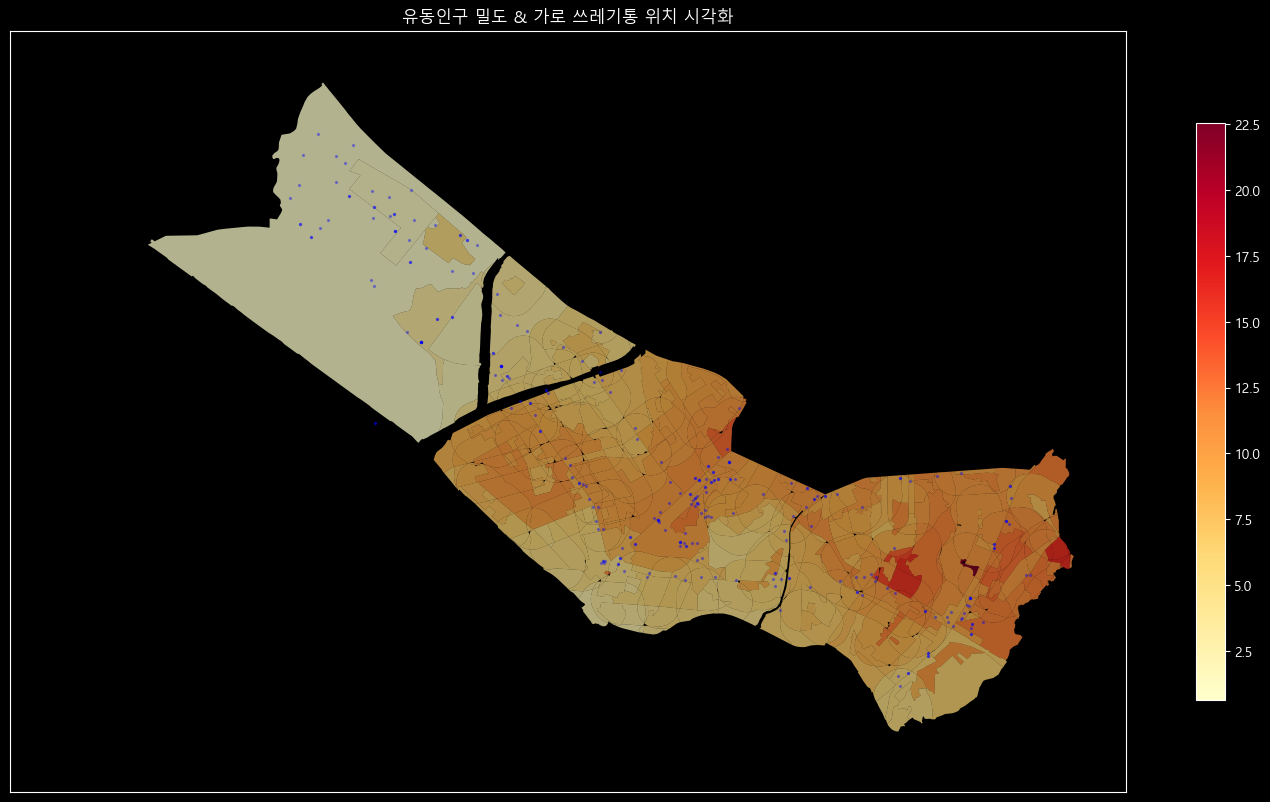

In [147]:
fig, ax = plt.subplots(figsize=(18, 15))
actual_df.set_geometry('geometry').plot(ax=ax, edgecolor='none', column='총_유동인구_수_밀도_평균', linewidth=0.1, cmap='YlOrRd', legend=True, alpha=0.7,
                                       legend_kwds={
                                         'shrink': 0.5,
                                         'aspect': 20,
                                         'orientation': "vertical"
                                       })
trash_mapo.plot(ax=ax, color='blue', markersize=2, alpha=0.3)
if not gu_mapo.empty:
  margin = 500
  x_min, y_min, x_max, y_max = gu_mapo.total_bounds

  ax.set_xlim(x_min - margin, x_max + margin)
  ax.set_ylim(y_min - margin, y_max + margin)

  ax.set_xticks([])
  ax.set_yticks([])
ax.grid(visible=False)
title = "유동인구 밀도 & 가로 쓰레기통 위치 시각화"
ax.set_title(title)
plt.savefig(os.path.join(config.PROJECT_ROOT, 'visualization', title+'.png'), dpi=400)
plt.show()